In [1]:
# Data preprocessing and modeling libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc)

# Neural network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Visualization and data handling
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import os

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All modeling libraries imported successfully.")


All modeling libraries imported successfully.


In [2]:
df = pd.read_csv('../data/telco_churn_cleaned.csv')

print("Dataset loaded from EDA:")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nTotalCharges data type: {df['TotalCharges'].dtype}")
print(f"Missing values in TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Drop customerID if it's not useful for prediction
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

print(f"\nData loaded successfully. Shape after removing customerID: {df.shape}")


Dataset loaded from EDA:
Shape: 7043 rows, 22 columns

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... TechSupport  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   
3  No phone service             DSL            Yes  ...         Yes   
4                No     Fiber optic             No  ...          No   

  StreamingTV Streami

In [3]:
df_processed = df.copy()

df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

# Binary categorical columns (convert to 0/1)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].map({'Yes': 1, 'No': 0})

# Gender (convert to 0/1)
if 'gender' in df_processed.columns:
    df_processed['gender'] = df_processed['gender'].map({'Male': 1, 'Female': 0})

# SeniorCitizen might be text from EDA 
if 'SeniorCitizen' in df_processed.columns:
    if df_processed['SeniorCitizen'].dtype == 'object':
        df_processed['SeniorCitizen'] = df_processed['SeniorCitizen'].map({'Yes': 1, 'No': 0})

print("Binary encoding completed!")

# Multi-category columns  (using One-Hot Encoding)
multi_category_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

cols_to_encode = [col for col in multi_category_cols if col in df_processed.columns]

# Applying one-hot encoding
df_encoded = pd.get_dummies(df_processed, columns=cols_to_encode, drop_first=True)

print(f"\nShape after encoding: {df_encoded.shape}")
print(f"Features increased from {df.shape[1]} to {df_encoded.shape[1]} columns")
print("\n All categorical variables encoded.")


Binary encoding completed!

Shape after encoding: (7043, 32)
Features increased from 21 to 32 columns

 All categorical variables encoded.


In [ ]:
# Separate features (X) and target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print("Feature columns:", X.shape[1])
print("Total samples:", len(y))
print(f"\nClass distribution:\n{y.value_counts()}")
print(f"\nChurn rate: {y.mean()*100:.2f}%")

# Split data - 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print("\nData split completed.")


Feature columns: 31
Total samples: 7043

Class distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn rate: 26.54%

Training set: 5634 samples
Testing set: 1409 samples

Data split completed!


In [5]:
scaler = StandardScaler()

# Fit on training data and transform both train and test (this is important for NN)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Feature scaling completed using StandardScaler")
print(f"\nTraining set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")
print("\nFeatures are scaled successfully.")


Feature scaling completed using StandardScaler

Training set shape: (5634, 31)
Testing set shape: (1409, 31)

Features are scaled successfully.


In [6]:
def create_neural_network(input_dim):
    model = Sequential([
        # Input layer, First hidden layer
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),  # to prevent overfitting
        
        # Second hidden layer
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        # Output layer for binary classification
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
nn_model = create_neural_network(X_train_scaled.shape[1])

# Display model architecture
print("Neural Network Architecture:")
nn_model.summary()
print("\nNeural Network model created.")


Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161 (16.25 KB)

 Trainable params: 4,161 (16.25 KB)

 Non-trainable params: 0 (0.00 B)


Neural Network model created.


Training Neural Network...
This may take a few minutes...

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8613 - loss: 0.3262 - val_accuracy: 0.9805 - val_loss: 0.0874
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9865 - loss: 0.0604 - val_accuracy: 0.9991 - val_loss: 0.0071
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 3.6835e-04
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 1.6612e-04
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 7.6636e-05
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 5.3457e-05
Epoch 8/100
141/141 ━━

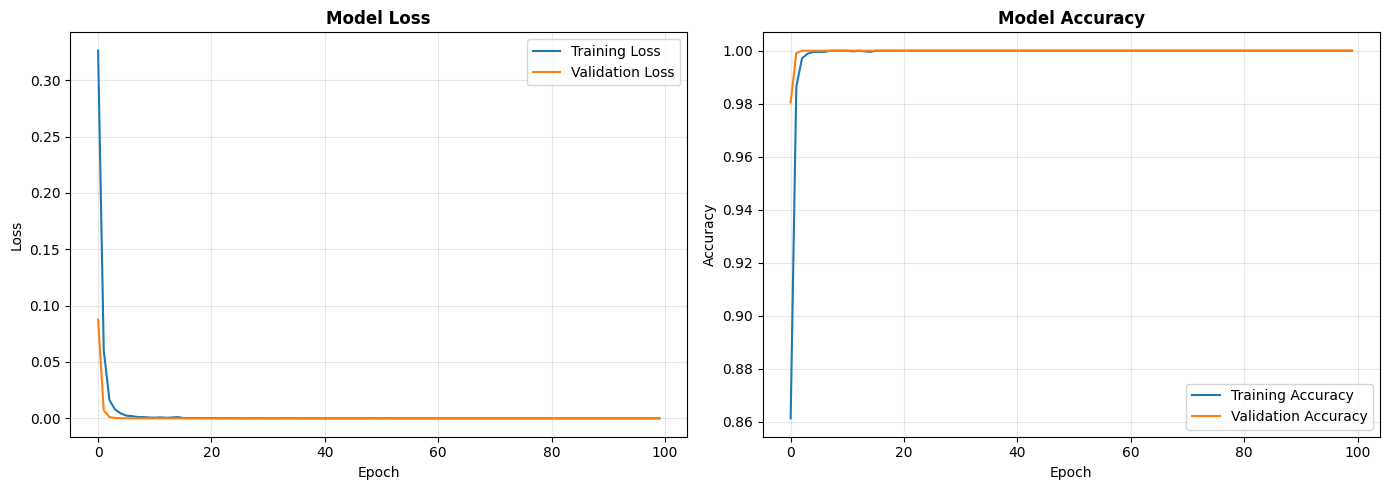

In [ ]:
# Early stopp - to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# To train the model
print("Training Neural Network...")

history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # using da 20% of training data for validation
    callbacks=[early_stop],
    verbose=1
)

print("\n Neural Network training completed.")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


............................
NEURAL NETWORK PERFORMANCE
............................
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

Confusion Matrix:
[[1035    0]
 [   0  374]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      1035
       Churn       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



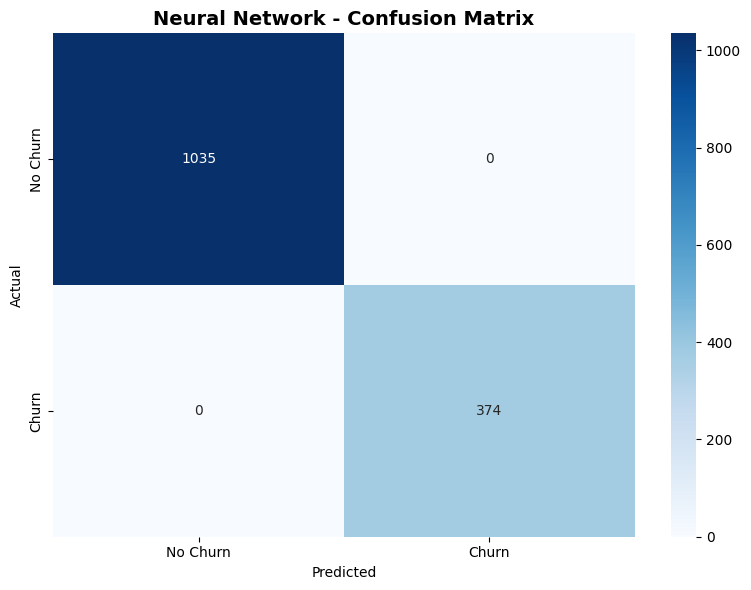


 Neural Network evaluation completed.


In [ ]:
# Making prediction
y_pred_nn_proba = nn_model.predict(X_test_scaled, verbose=0).flatten()
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)

# Calculate metrics
nn_accuracy = accuracy_score(y_test, y_pred_nn)
nn_precision = precision_score(y_test, y_pred_nn)
nn_recall = recall_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)
nn_roc_auc = roc_auc_score(y_test, y_pred_nn_proba)

print("."*28)
print("Neural Network Performance")
print("."*28)
print(f"Accuracy:  {nn_accuracy:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall:    {nn_recall:.4f}")
print(f"F1-Score:  {nn_f1:.4f}")
print(f"ROC-AUC:   {nn_roc_auc:.4f}")

print("\nConfusion Matrix:")
cm_nn = confusion_matrix(y_test, y_pred_nn)
print(cm_nn)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn']))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Neural Network - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\n Neural Network evaluation completed.")


In [17]:
dt_model = DecisionTreeClassifier(random_state=42)

# Train the decision tree model
print("Training Decision Tree...")
dt_model.fit(X_train, y_train)

# Make prediction
y_pred_dt = dt_model.predict(X_test)
y_pred_dt_proba = dt_model.predict_proba(X_test)[:, 1]

# Calculate metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_roc_auc = roc_auc_score(y_test, y_pred_dt_proba)

print("\n" + "."*44)
print("Decision tree performance (Before Tuning)")
print("."*44)
print(f"Accuracy:  {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall:    {dt_recall:.4f}")
print(f"F1-Score:  {dt_f1:.4f}")
print(f"ROC-AUC:   {dt_roc_auc:.4f}")

print("\n Decision Tree baseline model trained.")


Training Decision Tree...

............................................
Decision tree performance (Before Tuning)
............................................
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

 Decision Tree baseline model trained.


In [ ]:
# Defining the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Create GridSearchCV object
print("Starting hyperparameter tuning for Decision Tree...")

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # optimizing for ROC-AUC
    n_jobs=-1,  # using all CPU cores
    verbose=1
)

grid_search.fit(X_train, y_train)

# Getting best parameters
print("\n" + "."*27)
print("Best hyperparameters found")
print("."*27)
print(grid_search.best_params_)
print(f"\nBest cross-validation ROC-AUC score: {grid_search.best_score_:.4f}")

dt_best_model = grid_search.best_estimator_

print("\nHyperparameter tuning completed.")


Starting hyperparameter tuning for Decision Tree...
Fitting 5 folds for each of 224 candidates, totalling 1120 fits

...........................
Best hyperparameters found
...........................
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best cross-validation ROC-AUC score: 1.0000

Hyperparameter tuning completed.


...............................................
Decision tree performance (After Tuning)
...............................................
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

Confusion Matrix:
[[1035    0]
 [   0  374]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      1035
       Churn       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



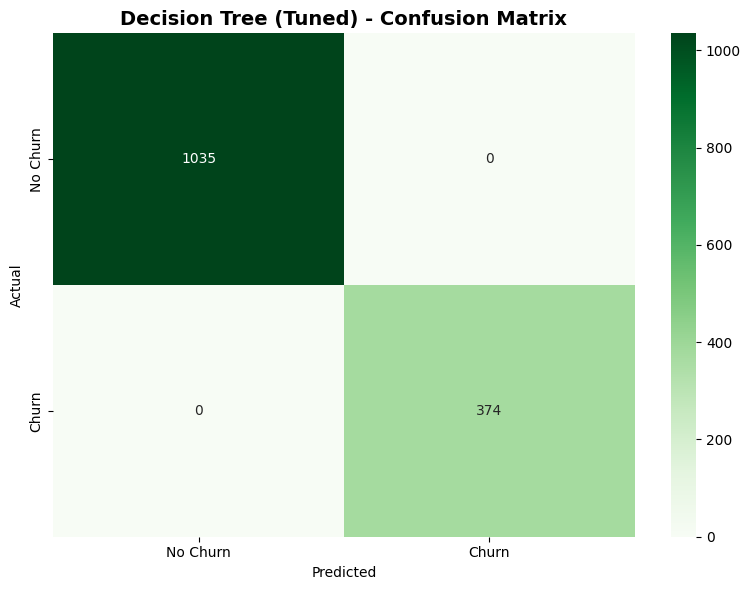


Tuned Decision Tree evaluation completed.


In [21]:
# Make predictions with da tuned model
y_pred_dt_tuned = dt_best_model.predict(X_test)
y_pred_dt_tuned_proba = dt_best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
dt_tuned_accuracy = accuracy_score(y_test, y_pred_dt_tuned)
dt_tuned_precision = precision_score(y_test, y_pred_dt_tuned)
dt_tuned_recall = recall_score(y_test, y_pred_dt_tuned)
dt_tuned_f1 = f1_score(y_test, y_pred_dt_tuned)
dt_tuned_roc_auc = roc_auc_score(y_test, y_pred_dt_tuned_proba)

print("."*47)
print("Decision tree performance (After Tuning)")
print("."*47)
print(f"Accuracy:  {dt_tuned_accuracy:.4f}")
print(f"Precision: {dt_tuned_precision:.4f}")
print(f"Recall:    {dt_tuned_recall:.4f}")
print(f"F1-Score:  {dt_tuned_f1:.4f}")
print(f"ROC-AUC:   {dt_tuned_roc_auc:.4f}")

print("\nConfusion Matrix:")
cm_dt = confusion_matrix(y_test, y_pred_dt_tuned)
print(cm_dt)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt_tuned, target_names=['No Churn', 'Churn']))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Decision Tree (Tuned) - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nTuned Decision Tree evaluation completed.")
